In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
from noah2 import data as D
from noah2 import util as U

In [3]:
import torch
from torch import nn 
from torch.utils.tensorboard.writer import SummaryWriter

from sbi import utils as Ut
from sbi import inference as Inference

In [4]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [5]:
cuda = torch.cuda.is_available()
device = ("cuda:0" if cuda else "cpu")

## load training and testing data

In [6]:
DNoah = D.Noah2()
data_train = DNoah._read_data(version='0.1', split='train')
data_test = DNoah._read_data(version='0.1', split='test')

In [12]:
# log10 scale some of the columns to reduce dynamical scale
data_train[:,0] = np.log10(data_train[:,0])
data_train[:,3] = np.log10(data_train[:,3])
data_train[:,4] = np.log10(data_train[:,4])

data_test[:,0] = np.log10(data_test[:,0])
data_test[:,3] = np.log10(data_test[:,3])
data_test[:,4] = np.log10(data_test[:,4])

## set $Y$ prior 

In [14]:
# prior 
lower_bounds = torch.tensor([1])
upper_bounds = torch.tensor([9])
prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device=device)

# train $q_\phi(Y\,|\,X)$

In [16]:
n_blocks = 2
n_transf = 2
n_hidden = 64
l_rate = 1e-3
n_comp = 2

neural_posterior = Ut.posterior_nn('made', 
        hidden_features=n_hidden, 
        num_transforms=n_transf, 
        num_blocks=n_blocks, 
        num_mixture_components=n_comp, 
        use_batch_norm=True)

anpe = Inference.SNPE(prior=prior,
        density_estimator=neural_posterior,
        device=device)

anpe.append_simulations( 
        torch.tensor(data_train[:,:1], dtype=torch.float32).to(device), 
        torch.tensor(data_train[:,1:], dtype=torch.float32).to(device))

qphi_y_x = anpe.train(
        training_batch_size=50,
        learning_rate=l_rate, 
        show_train_summary=True)

# save trained NPE  
qphi    = anpe.build_posterior(qphi_y_x)

/opt/anaconda3/envs/noah/lib/python3.7/site-packages/sbi/neural_nets/flow.py:62: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 46 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 46
        Best validation performance: -0.7118
        -------------------------
        


# validate trained $q_\phi$
Sample $Y_i'\sim q_\phi(Y\,|\,X^{\rm test}_i)$ and compare against $Y^{\rm test}_i$

In [19]:
n_sample = 10000

y_nde, ranks = [], []
for i in tqdm(np.arange(data_test.shape[0])): 
    _samp = qphi.sample((n_sample,), 
                        x=torch.tensor(data_test[i,1:], dtype=torch.float32).to(device), 
                        show_progress_bars=False)
    y_nde.append(_samp.detach().cpu().numpy())
    ranks.append(np.mean(y_nde[-1] < data_test[i,0]))
    
y_nde = np.array(y_nde)
ranks = np.array(ranks)

  0%|          | 0/16737 [00:00<?, ?it/s]

[]

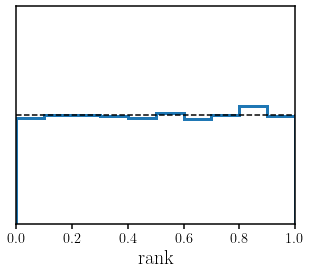

In [32]:
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(111)
_ = sub.hist(ranks, range=(0, 1), bins=10, density=True, histtype='step', linewidth=3)
sub.plot([0., 1.], [1., 1.], c='k', ls='--')

sub.set_xlabel('rank', fontsize=20)
sub.set_xlim(0, 1)
sub.set_ylim(0., 2.)
sub.set_yticks([])
sub.set_yticklabels([])

In [33]:
from tarp import get_drp_coverage

ModuleNotFoundError: No module named 'tarp'

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot([0, 1], [0, 1], ls="--", color="k")
alpha, ecp = get_drp_coverage(np.swapaxes(y_nde, 0, 1), data_test[:,0][:,None], 
                              references="random", metric="euclidean")
ax.plot(alpha, ecp, color='C0', label='$q_\phi$') 

ax.legend(loc='lower right', handletextpad=0.1, fontsize=25)
ax.set_ylabel("Expected Coverage", fontsize=25)
ax.set_ylim(0., 1.)
ax.set_xlabel("Credibility Level", fontsize=25)
ax.set_xlim(0., 1.)